# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Topic Detection 
### Zero-shot (NLI) modeling based on Sentiment Analysis

Shijia Huang

-----

In [1]:
#!pip install -r requirements.txt

In [2]:
# Import basic libraries
import os
import sys
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import tensorflow as tf
from transformers import pipeline

2023-05-19 20:45:22.660380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.5.2


In [5]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


### Read New Articles with Sentiment Score

In [7]:
%%time

# GCP version
#path = "gs://nlp-final-project-data/data/"
#df_news = pd.read_parquet(path + 'news_sentiment.parquet', engine='pyarrow')

# Sagemaker version
df_news = pd.read_parquet('data_news_sentiment.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 7s, sys: 10.8 s, total: 1min 18s
Wall time: 1min 8s


(154283, 11)

In [8]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154283 entries, 0 to 154282
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154283 non-null  int64 
 1   date              154283 non-null  object
 2   cleaned title     154283 non-null  object
 3   cleaned text      154283 non-null  object
 4   title_tokens      154283 non-null  object
 5   title_lemmatized  154283 non-null  object
 6   text_tokens       154283 non-null  object
 7   text_lemmatized   154283 non-null  object
 8   title_keywords    154283 non-null  object
 9   text_keywords     154283 non-null  object
 10  sentiment         154283 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 12.9+ MB


In [9]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]",5
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, ne

In [10]:
### SAMPLE DATA
# df_news = df_news.sample(frac=0.01, random_state=42)
df_news.shape

(154283, 11)

## Select articles with positive and negative sentiment scores

- Positive: sentiment score > 3
- Negative: sentiment score < 3

In [11]:
# select positive sentiment articles
df_news_positive = df_news[df_news['sentiment'] > 3].reset_index(drop=True)
df_news_positive.shape

(104228, 11)

In [12]:
# print a sample
df_news_positive.sample(1)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
44619,85850,2021-10-14,Aicadium and SambaNova join forces to bring innovative end-to-end hardware and software AI solution to Singapore,"Aicadium and SambaNova join forces to bring innovative endtoend hardware and software AI solution to SingaporePartnership accelerates access to industry impacting AI capabilities for organisations in the ASEAN region and beyond.Published: Oct. 13, 2021 at 7:16 PM CDTUpdated: 1 hour agoSINGAPOREand PALO ALTO, Calif., Oct. 13, 2021 PRNewswire Aicadium, a global technology company founded by Temasek dedicated to creating and scaling AI solutions, and SambaNova, the company building the industr...","[aicadium, sambanova, join, forces, bring, innovative, endtoend, hardware, software, ai, solution, singapore, aicadium, sambanova_join, forces, bring_innovative, endtoend_hardware, software, ai, solution, singapore, aicadium, sambanova_join, forces, bring_innovative_endtoend_hardware, software, ai_solution, singapore]","[aicadium, sambanova, join, force, bring, innovative, endtoend, hardware, software, ai, solution, singapore, aicadium, sambanova_join, force, software, ai, solution, singapore, aicadium, sambanova_join, force, bring_innovative_endtoend_hardware, software, ai_solution, singapore]","[aicadium, sambanova, join, forces, bring, innovative, endtoend, hardware, software, ai, solution, accelerates, access, industry, impacting, ai, capabilities, organisations, asean, region, beyond, published, oct, pm, cdtupdated, hour, agosingaporeand, palo, alto, calif, oct, prnewswire, aicadium, global, technology, company, founded, temasek, dedicated, creating, scaling, ai, solutions, sambanova, company, building, industrys, advanced, software, hardware, services, run, ai, applications, to...","[join, force, bring, innovative, endtoend, hardware, software, solution, accelerate, access, industry, impacting, ai, capability, organisation, region, publish, pm, cdtupdate, hour, aicadium, global, technology, company, found, temasek, dedicated, create, scaling, ai, solution, build, advanced, software, hardware, service, run, ai, application, today, announce, partnership, bring, advance, hardware, conjunction, aicadium, ai, platform, solution, available, company, singapore, seek, deploy, m...","[software, singapore, force, aicadium, solution, sambanova_join, ai, sambanova, join, innovative]","[ai, solution, company, aicadium, system, platform, organisation, global, build, industry]",4


In [13]:
# select negative sentiment articles
df_news_negative = df_news[df_news['sentiment'] < 3].reset_index(drop=True)
df_news_negative.shape

(14932, 11)

In [14]:
# print a sample
df_news_negative.sample(1)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
4053,54722,2023-03-29,"‘Out of control’ AI is a threat to civilisation, warns Elon Musk","Out of control AI is a threat to civilisation, warns Elon MuskRead full articleGareth CorfieldMarch 29, 2023, 5:33 a.m.2 min readElon Musk gestures as he speaks during a press conference JIM WATSONAFP via Getty ImagesElon Musk has warned that out of control development of artificial intelligence AI could pose profound risks to society and humanity.The Tesla chief and thousands of other academics and tech industry figures have signed an open letter demanding that all AI labs... immediately p...","[control, ai, threat, civilisation, warns, elon, musk, control, ai, threat, civilisation, warns, elon_musk, control, ai_threat, civilisation, warns, elon_musk]","[control, ai, threat, civilisation, warn, elon, musk, control, ai, threat, civilisation, warn, elon_musk, control, ai_threat, civilisation, warn, elon_musk]","[control, ai, threat, civilisation, warns, elon, muskread, full, articlegareth, corfieldmarch, min, readelon, musk, gestures, speaks, press, conference, jim, watsonafp, via, getty, imageselon, musk, warned, control, development, artificial, intelligence, ai, could, pose, profound, risks, society, humanity, tesla, chief, thousands, academics, tech, industry, figures, signed, open, letter, demanding, ai, labs, immediately, pause, work, advancing, ai, called, governments, temporarily, ban, rese...","[ai, threat, civilisation, warn, muskread, full, articlegareth, corfieldmarch, min, readelon, musk, gesture, speak, press, getty, imageselon, warn, artificial, intelligence, ai, pose, profound, risk, society, humanity, tesla, chief, thousand, academic, tech, industry, figure, sign, open, letter, demand, ai, immediately, pause, work, advance, ai, call, government, temporarily, ban, research, signatory, include, apple, cofounder, doomsday, alarm, recent, rapid, advance, ai, development, unelec...","[warn, control, civilisation, threat, elon_musk, ai, musk, elon, ai_threat]","[ai, say, new, water, space, government, take, discover, find, hour]",2


## Topic Modeling - Zero-shot (NLI) modeling

Using candidate labels from LDA model with n=18 topics

#### Check for GPU presence

In [15]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
!nvidia-smi

Sat May 20 00:52:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
tf.__version__

'2.11.1'

In [18]:
#!pip install torch --upgrade

In [19]:
#!pip install ktrain --upgrade

In [20]:
#!python3 -m pip install tensorflow

In [21]:
import ktrain
import torch

### Modelling

In [22]:
zsl = ktrain.text.ZeroShotClassifier()

In [23]:
candidate_labels = ['digital transaction', 'healthcare', 'news platform', 'data analytics', 'insurance', 'investment', 'global market', 'autonomous car', 'customer experience', 'data science', 'cryptocurrency', 'camera', 'robot', 'chatgpt', 'image', 'voice', 'patient care', 'research']
len(candidate_labels)

18

### Positive Sentiment Articles

In [23]:
# Put reviews in a list
seq_pos = df_news_positive['cleaned text'].sample(1000).to_list()

# Set the hyppothesis template
hypothesis_template = "The topic of this news article is {}."

In [ ]:
%%time

topic_pos = zsl.predict(seq_pos, 
                        labels=candidate_labels, 
                        include_labels=False, 
                        nli_template=hypothesis_template, 
                        batch_size=18)

CPU times: user 23min 36s, sys: 14min 4s, total: 37min 40s
Wall time: 35min 52s


In [ ]:
pos_pred_df = pd.DataFrame(topic_pos, columns=candidate_labels) 
pos_pred_df.head()

,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,0.189048,0.083276,0.404735,0.713980,0.048833,0.850423,0.983356,0.147552,0.309551,0.222135,0.069777,0.119665,0.168936,0.394003,0.333103,0.521404,0.112032,0.955376
1,0.971177,0.940174,0.996037,0.863431,0.056253,0.965887,0.934546,0.058829,0.938672,0.906139,0.100718,0.126258,0.119053,0.952202,0.931842,0.687049,0.673787,0.829878
2,0.549969,0.325538,0.870079,0.918746,0.397629,0.731781,0.385335,0.249390,0.777407,0.891850,0.139737,0.427788,0.280470,0.662784,0.752450,0.798037,0.200582,0.984621
3,0.855386,0.097613,0.962276,0.854594,0.066213,0.693219,0.998088,0.143273,0.964067,0.686721,0.048727,0.356305,0.380920,0.827936,0.877390,0.840519,0.088012,0.995317
4,0.700213,0.208949,0.770048,0.858501,0.190716,0.424776,0.628448,0.093216,0.920040,0.800532,0.081283,0.272123,0.432931,0.262712,0.536358,0.648307,0.110431,0.609417


In [ ]:
pos_pred_df.shape

(1000, 18)

In [ ]:
# SAVE THE RESULTS
pos_pred_df.to_json('result/pos_pred.json', orient='records', lines=True)

In [ ]:
pos_news_topics = df_news_positive.join(pos_pred_df, how='inner')
pos_news_topics = pos_news_topics[['id', 'cleaned text', 'sentiment'] + candidate_labels]

# Reset multi-level index
pos_news_topics.columns = pos_news_topics.columns.get_level_values(0)

# Select the small-ish articles only
pos_news_topics.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,1,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...",5,0.189048,0.083276,0.404735,0.713980,0.048833,0.850423,0.983356,0.147552,0.309551,0.222135,0.069777,0.119665,0.168936,0.394003,0.333103,0.521404,0.112032,0.955376
1,2,"Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...",4,0.971177,0.940174,0.996037,0.863431,0.056253,0.965887,0.934546,0.058829,0.938672,0.906139,0.100718,0.126258,0.119053,0.952202,0.931842,0.687049,0.673787,0.829878


In [ ]:
pos_news_topics.shape

(1000, 21)

In [ ]:
# SAVE THE RESULTS
pos_news_topics.to_json('result/pos_news_topics.json', orient='records', lines=True)

In [ ]:
pos_news_topics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1000 non-null   int64  
 1   cleaned text         1000 non-null   object 
 2   sentiment            1000 non-null   int64  
 3   digital transaction  1000 non-null   float64
 4   healthcare           1000 non-null   float64
 5   news platform        1000 non-null   float64
 6   data analytics       1000 non-null   float64
 7   insurance            1000 non-null   float64
 8   investment           1000 non-null   float64
 9   global market        1000 non-null   float64
 10  autonomous car       1000 non-null   float64
 11  customer experience  1000 non-null   float64
 12  data science         1000 non-null   float64
 13  cryptocurrency       1000 non-null   float64
 14  camera               1000 non-null   float64
 15  robot                1000 non-null   float64

### Negetive Sentiment Articles

In [26]:
# Put reviews in a list
seq_neg = df_news_negative['cleaned text'].sample(1000).to_list()

# Set the hyppothesis template
hypothesis_template = "The topic of this news article is {}."

In [ ]:
%%time

topic_neg = zsl.predict(seq_neg, 
                        labels=candidate_labels, 
                        include_labels=False, 
                        nli_template=hypothesis_template, 
                        batch_size=18)

CPU times: user 21min 29s, sys: 12min 55s, total: 34min 25s
Wall time: 32min 30s


In [ ]:
neg_pred_df = pd.DataFrame(topic_neg, columns=candidate_labels)
neg_pred_df.head()

,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,0.520370,0.112797,0.747345,0.642699,0.054052,0.187685,0.775824,0.039266,0.662619,0.514457,0.035682,0.179212,0.462046,0.876484,0.296175,0.683526,0.085167,0.555365
1,0.091209,0.003056,0.635477,0.033356,0.002520,0.009066,0.311910,0.001832,0.045789,0.136891,0.003965,0.007374,0.067747,0.995085,0.112712,0.330906,0.005189,0.981931
2,0.830772,0.053557,0.937766,0.872668,0.081875,0.383067,0.837185,0.341534,0.538601,0.847025,0.021629,0.285224,0.607073,0.962344,0.945322,0.900375,0.060884,0.892582
3,0.150539,0.010173,0.761225,0.921766,0.026464,0.860801,0.296030,0.003235,0.945704,0.935439,0.007286,0.044527,0.090656,0.199957,0.305413,0.252674,0.006992,0.966840
4,0.083841,0.054111,0.120562,0.008824,0.006225,0.008848,0.049754,0.003521,0.057006,0.012429,0.002367,0.010106,0.032996,0.607921,0.365569,0.033469,0.022034,0.168864


In [ ]:
neg_pred_df.shape

(1000, 18)

In [ ]:
# SAVE THE RESULTS
neg_pred_df.to_json('result/neg_pred.json', orient='records', lines=True)

In [ ]:
neg_news_topics = df_news_negative.join(neg_pred_df, how='inner')
neg_news_topics = neg_news_topics[['id', 'cleaned text', 'sentiment'] + candidate_labels]

# Reset multi-level index
neg_news_topics.columns = neg_news_topics.columns.get_level_values(0)

# Select the small-ish articles only
neg_news_topics.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,5,"Cr Bard Inc Has Returned 48.9 Since SmarTrend Recommendation BCR SmarTrend identified an Uptrend for Cr Bard Inc :BCR on December 23rd, 2016 at 222.45. In approximately 40 months, Cr Bard Inc has returned 48.91 as of todays recent price of 331.24.In the past 52 weeks, Cr Bard Inc share prices have been bracketed by a low of 0.00 and a high of 0.00 and are now at 331.24, 100 above that low price. In the last five trading sessions, the 50day moving average MA has remained constant while the...",2,0.520370,0.112797,0.747345,0.642699,0.054052,0.187685,0.775824,0.039266,0.662619,0.514457,0.035682,0.179212,0.462046,0.876484,0.296175,0.683526,0.085167,0.555365
1,12,"Conversational AI Marketplace Enlargement Possibilities, Regional Traits and Call for, Most sensible Avid gamers, Alternatives with Forecasts 2025 International Conversational AI marketplace 2020 analysis document is a solitary instrument that provides an indepth scrutiny of various Conversational AI marketplace insights, alternatives, collateral approaches and more than a few techniques of creating robust determinations. The Conversational AI marketplace CAGR charge would possibly building...",2,0.091209,0.003056,0.635477,0.033356,0.002520,0.009066,0.311910,0.001832,0.045789,0.136891,0.003965,0.007374,0.067747,0.995085,0.112712,0.330906,0.005189,0.981931


In [ ]:
neg_news_topics.shape

(1000, 21)

In [ ]:
# SAVE THE RESULTS
neg_news_topics.to_json('result/neg_news_topics.json', orient='records', lines=True)

## Analysis of Zero-shot (NLI) Modeling Results

In [86]:
candidate_labels = ['digital transaction', 'healthcare', 'news platform', 'data analytics', 'insurance', 'investment', 'global market', 'autonomous car', 'customer experience', 'data science', 'cryptocurrency', 'camera', 'robot', 'chatgpt', 'image', 'voice', 'patient care', 'research']
len(candidate_labels)

18

In [87]:
pos_nil = pd.read_json('result/pos_news_topics.json', orient='records', lines=True)
pos_nil.shape

(1000, 21)

In [88]:
pos_nil.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,1,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...",5,0.189048,0.083276,0.404735,0.713980,0.048833,0.850423,0.983356,0.147552,0.309551,0.222135,0.069777,0.119665,0.168936,0.394003,0.333103,0.521404,0.112032,0.955376
1,2,"Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...",4,0.971177,0.940174,0.996037,0.863431,0.056253,0.965887,0.934546,0.058829,0.938672,0.906139,0.100718,0.126258,0.119053,0.952202,0.931842,0.687049,0.673787,0.829878


In [89]:
neg_nil = pd.read_json('result/neg_news_topics.json', orient='records', lines=True)
neg_nil.shape

(1000, 21)

In [90]:
neg_nil.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,5,"Cr Bard Inc Has Returned 48.9 Since SmarTrend Recommendation BCR SmarTrend identified an Uptrend for Cr Bard Inc :BCR on December 23rd, 2016 at 222.45. In approximately 40 months, Cr Bard Inc has returned 48.91 as of todays recent price of 331.24.In the past 52 weeks, Cr Bard Inc share prices have been bracketed by a low of 0.00 and a high of 0.00 and are now at 331.24, 100 above that low price. In the last five trading sessions, the 50day moving average MA has remained constant while the...",2,0.520370,0.112797,0.747345,0.642699,0.054052,0.187685,0.775824,0.039266,0.662619,0.514457,0.035682,0.179212,0.462046,0.876484,0.296175,0.683526,0.085167,0.555365
1,12,"Conversational AI Marketplace Enlargement Possibilities, Regional Traits and Call for, Most sensible Avid gamers, Alternatives with Forecasts 2025 International Conversational AI marketplace 2020 analysis document is a solitary instrument that provides an indepth scrutiny of various Conversational AI marketplace insights, alternatives, collateral approaches and more than a few techniques of creating robust determinations. The Conversational AI marketplace CAGR charge would possibly building...",2,0.091209,0.003056,0.635477,0.033356,0.002520,0.009066,0.311910,0.001832,0.045789,0.136891,0.003965,0.007374,0.067747,0.995085,0.112712,0.330906,0.005189,0.981931


In [91]:
# set relevence threshold
threshold = 0.85

### Positive Sentiment Article Topics

In [92]:
# select the relevant topics for positive sentiment articles
pos_nil_rel = pos_nil[(pos_nil['digital transaction'] > threshold) | (pos_nil['healthcare'] > threshold) | (pos_nil['news platform'] > threshold) | (pos_nil['data analytics'] > threshold) | (pos_nil['insurance'] > threshold) | (pos_nil['investment'] > threshold) | (pos_nil['global market'] > threshold) | (pos_nil['autonomous car'] > threshold) | (pos_nil['customer experience'] > threshold) | (pos_nil['data science'] > threshold) | (pos_nil['cryptocurrency'] > threshold) | (pos_nil['camera'] > threshold) | (pos_nil['robot'] > threshold) | (pos_nil['chatgpt'] > threshold) | (pos_nil['image'] > threshold) | (pos_nil['voice'] > threshold) | (pos_nil['patient care'] > threshold) | (pos_nil['research'] > threshold)].reset_index(drop=True)
pos_nil_rel.shape

(880, 21)

In [93]:
# convert the relevence scores to binary by setting the threshold
pos_nil_rel[candidate_labels] = pos_nil_rel[candidate_labels].applymap(lambda x: 1 if x > threshold else 0)
pos_nil_rel.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,1,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...",5,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
1,2,"Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...",4,1,1,1,1,0,1,1,0,1,1,0,0,0,1,1,0,0,0


In [94]:
# sum the binary values to get the count of relevant topics
pos_nil_rel['count'] = pos_nil_rel[candidate_labels].sum(axis=1)
pos_nil_rel.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research,count
0,1,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...",5,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,3
1,2,"Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...",4,1,1,1,1,0,1,1,0,1,1,0,0,0,1,1,0,0,0,10


In [95]:
pos_topic_freq = pd.DataFrame(pos_nil_rel[candidate_labels].sum(axis=0)).reset_index()
pos_topic_freq.columns = ['topic', 'count']
pos_topic_freq

,topic,count
0,digital transaction,122
1,healthcare,131
2,news platform,507
3,data analytics,315
4,insurance,10
5,investment,226
6,global market,391
7,autonomous car,15
8,customer experience,355
9,data science,288


In [96]:
# convert frequency to percentage
pos_topic_freq['percentage'] = round(pos_topic_freq['count'] / pos_nil_rel.shape[0] * 100, 2)
pos_topic_freq

,topic,count,percentage
0,digital transaction,122,13.86
1,healthcare,131,14.89
2,news platform,507,57.61
3,data analytics,315,35.80
4,insurance,10,1.14
5,investment,226,25.68
6,global market,391,44.43
7,autonomous car,15,1.70
8,customer experience,355,40.34
9,data science,288,32.73


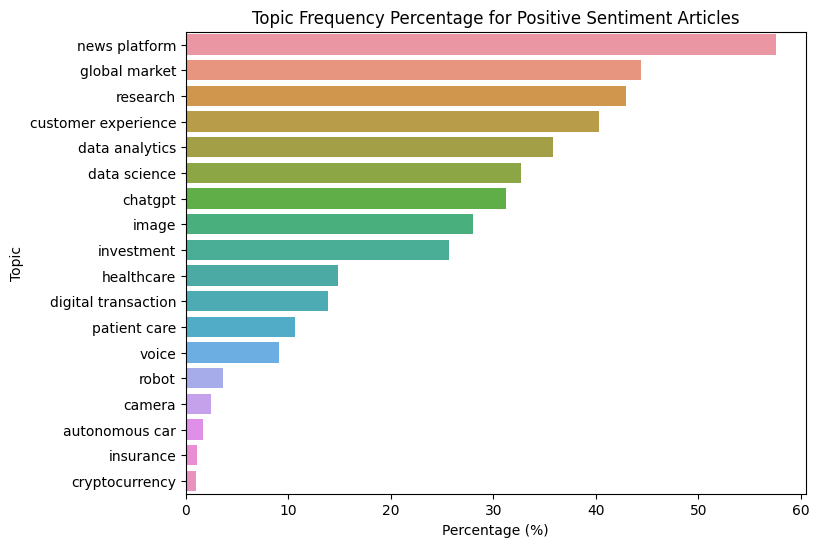

In [97]:
# make a vertical bar plot of the topic frequency pct and sort by count
plt.figure(figsize=(8, 6))
sns.barplot(x='percentage', y='topic', data=pos_topic_freq.sort_values(by='percentage', ascending=False))
plt.title('Topic Frequency Percentage for Positive Sentiment Articles')
plt.xlabel('Percentage (%)')
plt.ylabel('Topic')
plt.show()

### Negative Sentiment Article Topics

In [98]:
# select the relevant topics for negative sentiment articles
neg_nil_rel = neg_nil[(neg_nil['digital transaction'] > threshold) | (neg_nil['healthcare'] > threshold) | (neg_nil['news platform'] > threshold) | (neg_nil['data analytics'] > threshold) | (neg_nil['insurance'] > threshold) | (neg_nil['investment'] > threshold) | (neg_nil['global market'] > threshold) | (neg_nil['autonomous car'] > threshold) | (neg_nil['customer experience'] > threshold) | (neg_nil['data science'] > threshold) | (neg_nil['cryptocurrency'] > threshold) | (neg_nil['camera'] > threshold) | (neg_nil['robot'] > threshold) | (neg_nil['chatgpt'] > threshold) | (neg_nil['image'] > threshold) | (neg_nil['voice'] > threshold) | (neg_nil['patient care'] > threshold) | (neg_nil['research'] > threshold)].reset_index(drop=True)
neg_nil_rel.shape

(808, 21)

In [99]:
# convert the relevence scores to binary by setting the threshold
neg_nil_rel[candidate_labels] = neg_nil_rel[candidate_labels].applymap(lambda x: 1 if x > threshold else 0)
neg_nil_rel.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research
0,5,"Cr Bard Inc Has Returned 48.9 Since SmarTrend Recommendation BCR SmarTrend identified an Uptrend for Cr Bard Inc :BCR on December 23rd, 2016 at 222.45. In approximately 40 months, Cr Bard Inc has returned 48.91 as of todays recent price of 331.24.In the past 52 weeks, Cr Bard Inc share prices have been bracketed by a low of 0.00 and a high of 0.00 and are now at 331.24, 100 above that low price. In the last five trading sessions, the 50day moving average MA has remained constant while the...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,12,"Conversational AI Marketplace Enlargement Possibilities, Regional Traits and Call for, Most sensible Avid gamers, Alternatives with Forecasts 2025 International Conversational AI marketplace 2020 analysis document is a solitary instrument that provides an indepth scrutiny of various Conversational AI marketplace insights, alternatives, collateral approaches and more than a few techniques of creating robust determinations. The Conversational AI marketplace CAGR charge would possibly building...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [100]:
# sum the binary values to get the count of relevant topics
neg_nil_rel['count'] = neg_nil_rel[candidate_labels].sum(axis=1)
neg_nil_rel.head(2)

,id,cleaned text,sentiment,digital transaction,healthcare,news platform,data analytics,insurance,investment,global market,autonomous car,customer experience,data science,cryptocurrency,camera,robot,chatgpt,image,voice,patient care,research,count
0,5,"Cr Bard Inc Has Returned 48.9 Since SmarTrend Recommendation BCR SmarTrend identified an Uptrend for Cr Bard Inc :BCR on December 23rd, 2016 at 222.45. In approximately 40 months, Cr Bard Inc has returned 48.91 as of todays recent price of 331.24.In the past 52 weeks, Cr Bard Inc share prices have been bracketed by a low of 0.00 and a high of 0.00 and are now at 331.24, 100 above that low price. In the last five trading sessions, the 50day moving average MA has remained constant while the...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,12,"Conversational AI Marketplace Enlargement Possibilities, Regional Traits and Call for, Most sensible Avid gamers, Alternatives with Forecasts 2025 International Conversational AI marketplace 2020 analysis document is a solitary instrument that provides an indepth scrutiny of various Conversational AI marketplace insights, alternatives, collateral approaches and more than a few techniques of creating robust determinations. The Conversational AI marketplace CAGR charge would possibly building...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2


In [101]:
neg_topic_freq = pd.DataFrame(neg_nil_rel[candidate_labels].sum(axis=0)).reset_index()
neg_topic_freq.columns = ['topic', 'count']
neg_topic_freq

,topic,count
0,digital transaction,93
1,healthcare,77
2,news platform,463
3,data analytics,163
4,insurance,23
5,investment,210
6,global market,198
7,autonomous car,32
8,customer experience,202
9,data science,149


In [102]:
# convert frequency to percentage
neg_topic_freq['percentage'] = round(neg_topic_freq['count'] / neg_nil_rel.shape[0] * 100, 2)
neg_topic_freq

,topic,count,percentage
0,digital transaction,93,11.51
1,healthcare,77,9.53
2,news platform,463,57.30
3,data analytics,163,20.17
4,insurance,23,2.85
5,investment,210,25.99
6,global market,198,24.50
7,autonomous car,32,3.96
8,customer experience,202,25.00
9,data science,149,18.44


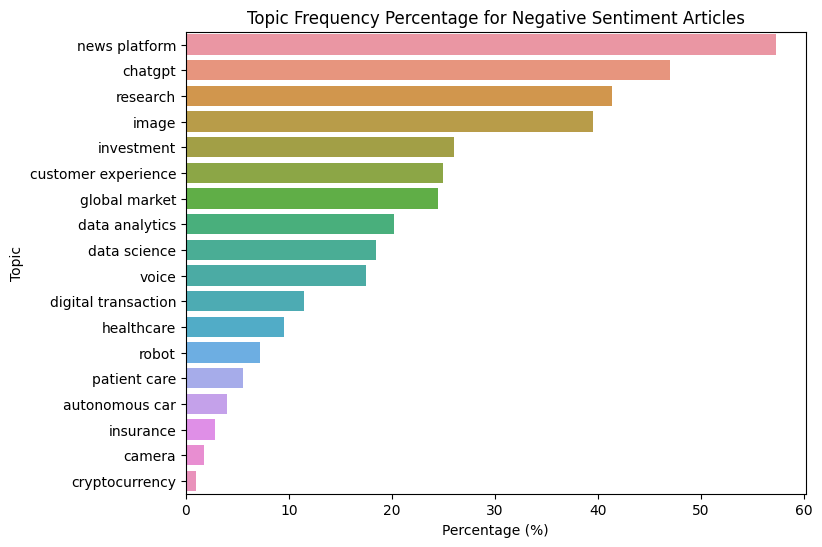

In [103]:
# make a vertical bar plot of the topic frequency pct and sort by count
plt.figure(figsize=(8, 6))
sns.barplot(x='percentage', y='topic', data=neg_topic_freq.sort_values(by='percentage', ascending=False))
plt.title('Topic Frequency Percentage for Negative Sentiment Articles')
plt.xlabel('Percentage (%)')
plt.ylabel('Topic')
plt.show()